# Condition differences

In [9]:
import pandas as pd
import numpy as np
import xarray as xr
import mne
import multiprocessing
import os
import itertools
import hmp
from mne.io import read_info
from matplotlib.gridspec import GridSpec
import bambi as bmb
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt


cpus = 4

# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
sfreq = 500 #at what sampling rate we want the data, downsampling to 100Hz is computationally less intensive for hmp instances

epoch_data_path = os.path.join('SAT_data/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'processed' in x]#Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder

epoch_data = hmp.utils.read_mne_data(subj_files, epoched=True, sfreq=sfreq, 
                            rt_col='RT', scale=1000,
                            verbose=False, subj_idx=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful
epoch_data['cue'] = epoch_data.cue.fillna(' ')
epoch_data['resp'] = epoch_data.resp.fillna(' ')
info = read_info(subj_files[0], verbose=False)

epoch_data *= 1e-6

Processing participant data/processed_500Hz_0012_epo.fif's epoched eeg
179 trials were retained for participant data/processed_500Hz_0012_epo.fif
Processing participant data/processed_500Hz_0009_epo.fif's epoched eeg
193 trials were retained for participant data/processed_500Hz_0009_epo.fif
Processing participant data/processed_500Hz_0015_epo.fif's epoched eeg
193 trials were retained for participant data/processed_500Hz_0015_epo.fif
Processing participant data/processed_500Hz_0025_epo.fif's epoched eeg
181 trials were retained for participant data/processed_500Hz_0025_epo.fif
Processing participant data/processed_500Hz_0007_epo.fif's epoched eeg
185 trials were retained for participant data/processed_500Hz_0007_epo.fif
Processing participant data/processed_500Hz_0017_epo.fif's epoched eeg
187 trials were retained for participant data/processed_500Hz_0017_epo.fif
Processing participant data/processed_500Hz_0016_epo.fif's epoched eeg
192 trials were retained for participant data/process

## Tranforming data, PCA, standardization

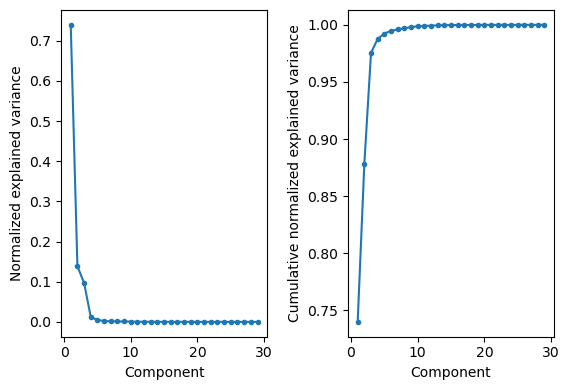

How many PCs (95 and 99% explained variance at component n3 and n5; components till n4 explain at least 1%)? 5


In [3]:
hmp_data = hmp.utils.transform_data(epoch_data)

## HMP in the Speed condition

In [4]:
# select the data
hmp_speed_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'SP', variable='cue') # select the conditions where participants needs to be fast
init_speed = hmp.models.hmp(hmp_speed_data, sfreq=epoch_data.sfreq, cpus=cpus)

  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Transition event 1 found around sample 59
Transition event 2 found around sample 138
Transition event 3 found around sample 274

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model


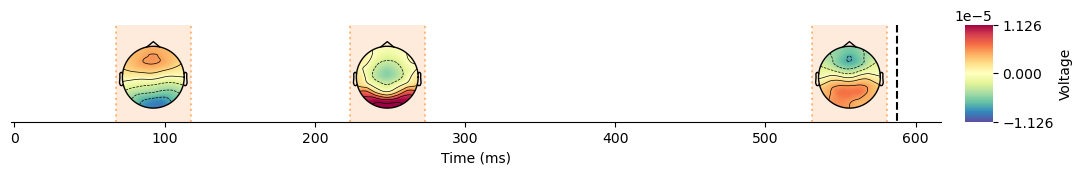

In [5]:
estimates_speed = init_speed.fit(tolerance=1e-6)
hmp.visu.plot_topo_timecourse(epoch_data, estimates_speed, info, init_speed, as_time=True)

## HMP in the Accuracy condition

We repeat the same analysis for the accuracy condition.

In [6]:
# select the data
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'AC', variable='cue') # select the conditions where participants needs to be accurate
init_accuracy = hmp.models.hmp(hmp_accuracy_data, sfreq=epoch_data.sfreq, cpus=cpus)

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Transition event 1 found around sample 60
Transition event 2 found around sample 150
Transition event 3 found around sample 252
Transition event 4 found around sample 463

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model


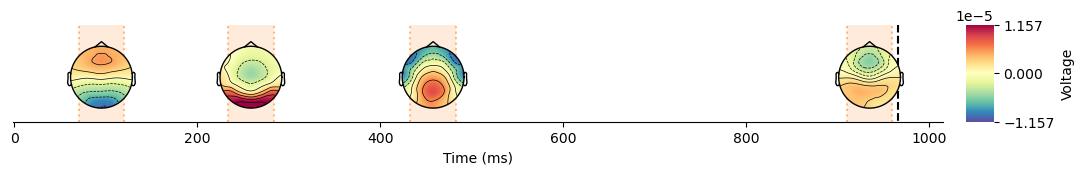

In [7]:
estimates_accuracy = init_accuracy.fit(tolerance=1e-6)
hmp.visu.plot_topo_timecourse(epoch_data, estimates_accuracy, info, init_accuracy, as_time=True)

## plotting together

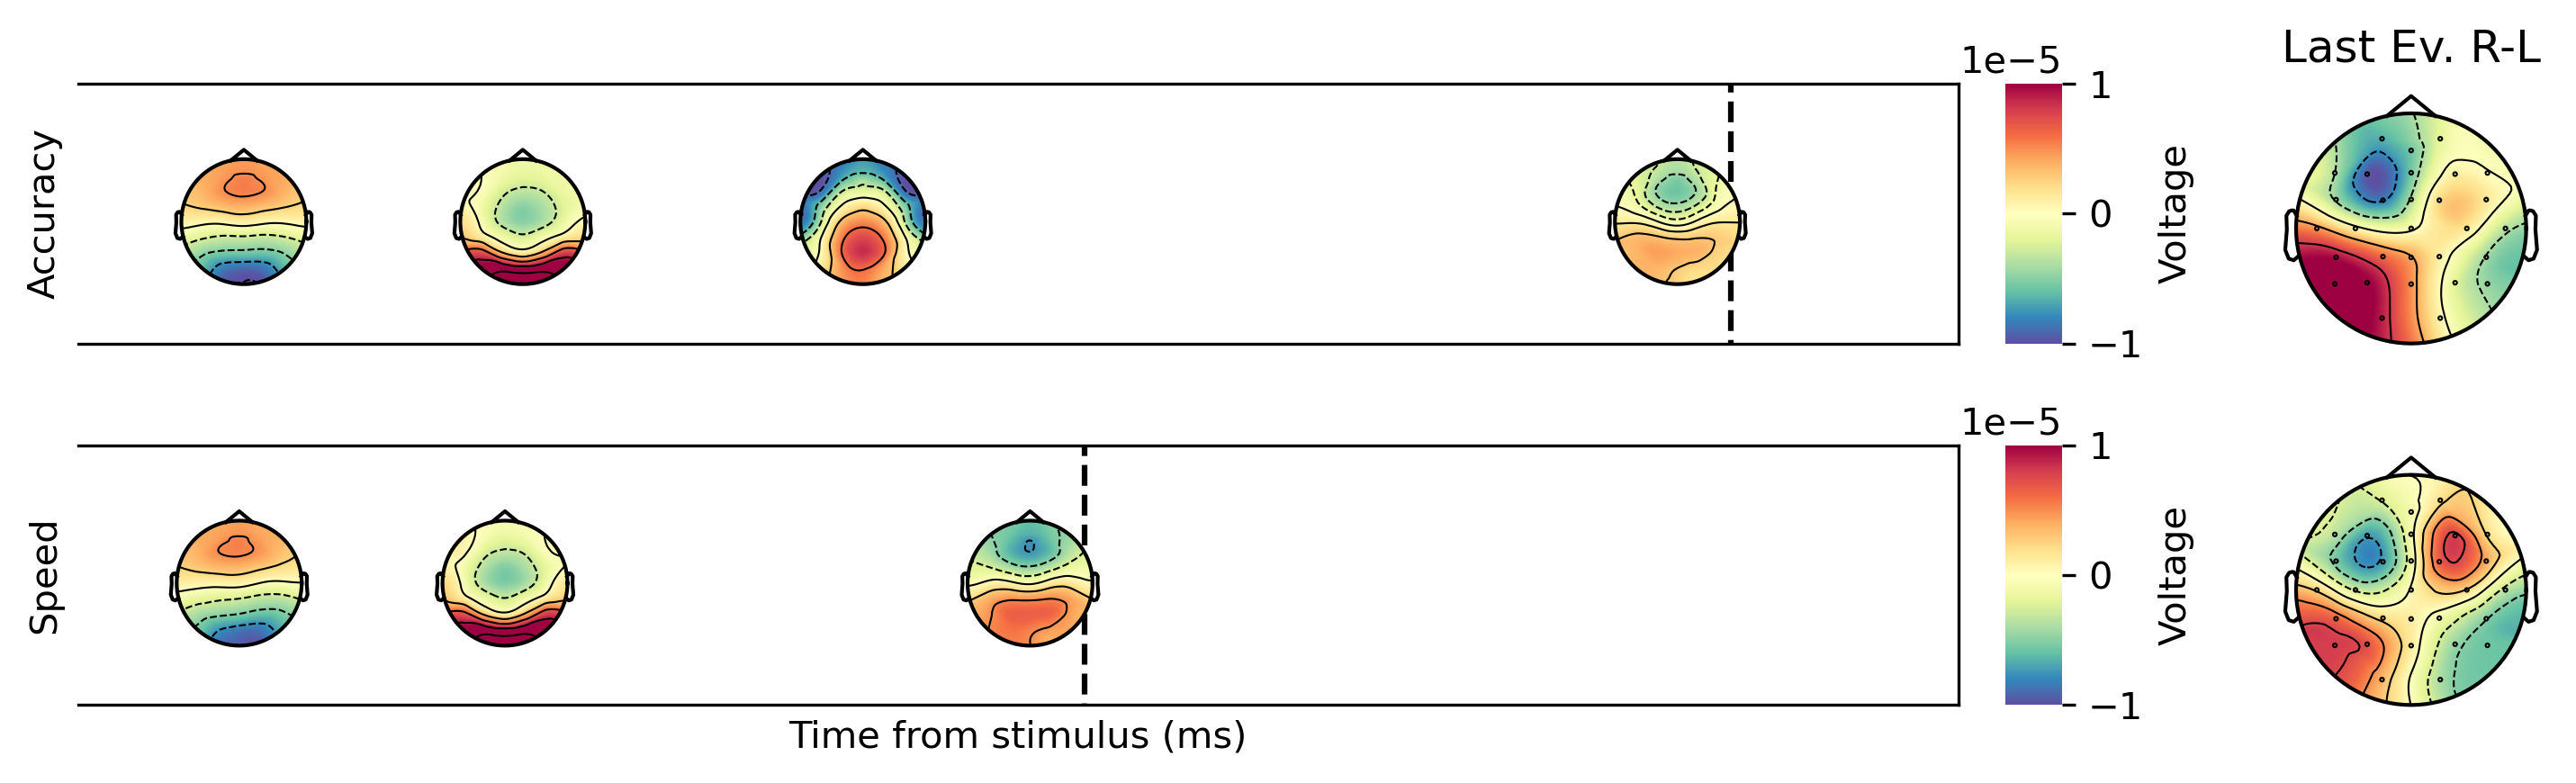

In [12]:
fig = plt.figure(figsize=(10, 3), dpi=300)
gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[1, 0])
ax0 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

ax_ = hmp.visu.plot_topo_timecourse(epoch_data, estimates_accuracy, info, init_accuracy, as_time=True, ax=ax0, event_lines=None, 
                                      max_time=1100, vmin=-1e-5, vmax=1e-5, colorbar=True)
ax0.set_ylabel('Accuracy')
ax0.set_xticks([])
ax_ = hmp.visu.plot_topo_timecourse(epoch_data, estimates_speed, info, init_speed, as_time=True, ax=ax1, event_lines=None, 
                                       max_time=1100, vmin=-1e-5, vmax=1e-5, colorbar=True)
ax1.set_ylabel('Speed')
ax1.set_xlabel('Time from stimulus (ms)')

ax2.set_title('Last Ev. R-L')
diffLRP_acc = init_accuracy.compute_topologies(hmp.utils.condition_selection_epoch(epoch_data, 'resp_right', variable='resp'), estimates_accuracy, init_accuracy) - \
                              init_accuracy.compute_topologies(hmp.utils.condition_selection_epoch(epoch_data, 'resp_left', variable='resp'), estimates_accuracy, init_accuracy)
diffLR = mne.viz.plot_topomap(diffLRP_acc[-1], info, axes=ax2, show=False, sensors=True, cmap='Spectral_r', vlim=(-1e-6, 1e-6))

diffLRP_spd = init_speed.compute_topologies(hmp.utils.condition_selection_epoch(epoch_data, 'resp_right', variable='resp'), estimates_speed, init_speed) - \
                              init_speed.compute_topologies(hmp.utils.condition_selection_epoch(epoch_data, 'resp_left', variable='resp'), estimates_speed, init_speed)
diffLR = mne.viz.plot_topomap(diffLRP_spd[-1], info, axes=ax3, show=False, sensors=True, cmap='Spectral_r', vlim=(-1e-6, 1e-6))



plt.tight_layout()
plt.savefig('HMP_solution_SAT.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


# Classifying events

In [14]:
def classification_true(true_topologies,test_topologies):
    true0 = np.vstack((np.zeros(true_topologies.shape[1]), true_topologies))#add a zero electrode event
    classif = np.zeros(test_topologies.shape[0], dtype=int)#array of categorization in true events
    classif_vals = np.zeros(test_topologies.shape[0])#values of the MSE
    for i, test_ev in enumerate(test_topologies):
        all_distances = np.zeros(len(true0))
        for j, true_ev in enumerate(true0):
            all_distances[j] = np.mean((true_ev-test_ev)**2)
        classif[i] = np.argmin(all_distances)
        classif_vals[i] = all_distances[classif[i]]
        
    mapping_true = {}
    for test_idx, (idx, val) in enumerate(zip(classif, classif_vals)):
        if idx > 0:
            if idx not in mapping_true or val < mapping_true[idx]:
                mapping_true[idx] = test_idx
                
    corresp_true_idx = np.array(list(mapping_true.keys()))-1#Corresponding true index, excluding 0 event
    idx_true_positive = np.array(list(mapping_true.values()))
    return idx_true_positive, corresp_true_idx

p3_topo = xr.open_dataarray("P3_topo.nc")
n2pc_topo = xr.open_dataarray("N2pc_topo.nc")
prev_topos = xr.concat([n2pc_topo, p3_topo], dim='event')
common_channels = list(set(epoch_data.channels.values) & set(prev_topos.channels.values))
prev_topos = prev_topos.sel(channels=common_channels)
prev_topo_name = np.array(["N2pc", "P3"])
inits = {"speed":init_speed, "accuracy":init_accuracy}
fits = {"speed":estimates_speed, "accuracy":estimates_accuracy}
for SAT in ["speed", "accuracy"]:
    sat_topos = inits[SAT].compute_topologies(epoch_data, fits[SAT], inits[SAT])
    sat_topos = sat_topos.sel(channels=common_channels)
    sat_index, prev_index = classification_true(prev_topos.values, sat_topos.values)
    print(f"Present topos in {SAT}: {prev_topo_name[prev_index]} at location {sat_index}")


Present topos in speed: ['N2pc'] at location [2]
Present topos in accuracy: ['N2pc' 'P3'] at location [1 2]


PearsonRResult(statistic=0.8872472192425568, pvalue=0.9999407829969864)
PearsonRResult(statistic=0.8778097489278063, pvalue=0.9999129349389198)
PearsonRResult(statistic=-0.9798785260579514, pvalue=1.2557380157867322e-08)


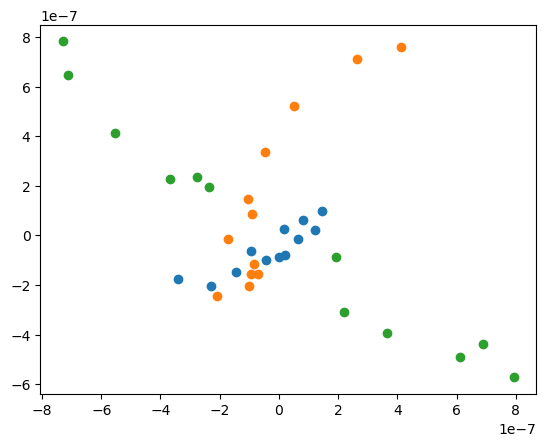

PearsonRResult(statistic=0.9708917371384835, pvalue=0.9999999216362566)
PearsonRResult(statistic=0.9732119241510422, pvalue=0.999999948067553)
PearsonRResult(statistic=0.9798038192379783, pvalue=0.9999999872093728)
PearsonRResult(statistic=-0.5978459169509789, pvalue=0.020029727742943707)


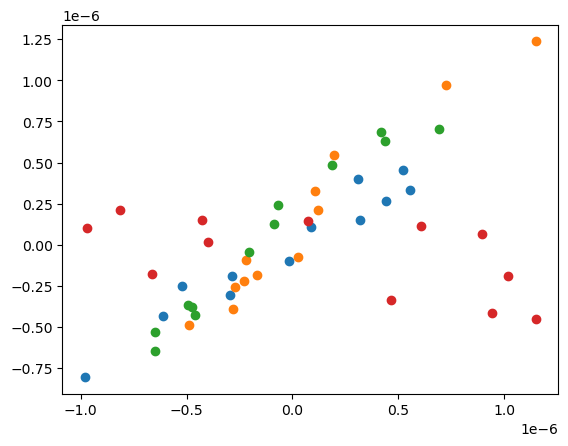

In [15]:
from scipy.stats import pearsonr
left_electrodes = ['Fp1', 'F3', 'F7', 'C3','P3', 'P7','T7', 'O1', 'FC1', 'FC5', 'CP1', 'CP5']

right_electrodes = ['Fp2', 'F4', 'F8', 'C4','P4', 'P8' ,'T8', 'O2', 'FC2', 'FC6', 'CP2', 'CP6']

for event in diffLRP_spd:
    plt.plot(event.sel(channels=left_electrodes).values, event.sel(channels=right_electrodes).values, 'o' )
    print(pearsonr(event.sel(channels=left_electrodes).values,event.sel(channels=right_electrodes).values, alternative='less'))
plt.show()
for event in diffLRP_acc:
    plt.plot(event.sel(channels=left_electrodes).values, event.sel(channels=right_electrodes).values, 'o' )
    print(pearsonr(event.sel(channels=left_electrodes).values,event.sel(channels=right_electrodes).values, alternative='less'))
plt.show()

## trial-aligned ERPs

In [16]:
times_accuracy = init_accuracy.compute_times(init_accuracy,estimates_accuracy, duration=False,fill_value=0, add_rt=True, as_time=True).unstack().to_dataframe(name='time')
times_speed = init_speed.compute_times(init_speed,estimates_speed, duration=False, fill_value=0, add_rt=True, as_time=True).unstack().to_dataframe(name='time')
times = pd.concat([times_speed.dropna(),times_accuracy.dropna()]).reset_index().set_index(['participant','trials'])

In [17]:
eeg_data_path = os.path.join('SAT_data/')#Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(eeg_data_path) if '_epo.fif' in x]#Extracting subject name based on the file name
subj_files = [eeg_data_path+x+'.fif' for x in subj_names]#Create a list of files that can be read from the folder
# 
epoch_data = hmp.utils.read_mne_data(subj_files, epoched=True, sfreq=sfreq, ignore_rt=True,
                            rt_col='RT', scale=1, 
                            verbose=False, subj_idx=subj_names)#Turning verbose off for the documentation but it is recommended to leave it on as some output from MNE might be useful
epoch_data

Processing participant SAT_data/processed_500Hz_0012_epo.fif's epoched eeg
188 trials were retained for participant SAT_data/processed_500Hz_0012_epo.fif
Processing participant SAT_data/processed_500Hz_0009_epo.fif's epoched eeg
195 trials were retained for participant SAT_data/processed_500Hz_0009_epo.fif
Processing participant SAT_data/processed_500Hz_0015_epo.fif's epoched eeg
194 trials were retained for participant SAT_data/processed_500Hz_0015_epo.fif
Processing participant SAT_data/processed_500Hz_0025_epo.fif's epoched eeg
181 trials were retained for participant SAT_data/processed_500Hz_0025_epo.fif
Processing participant SAT_data/processed_500Hz_0007_epo.fif's epoched eeg
185 trials were retained for participant SAT_data/processed_500Hz_0007_epo.fif
Processing participant SAT_data/processed_500Hz_0017_epo.fif's epoched eeg
187 trials were retained for participant SAT_data/processed_500Hz_0017_epo.fif
Processing participant SAT_data/processed_500Hz_0016_epo.fif's epoched eeg
1

<xarray.Dataset> Size: 2GB
Dimensions:      (epochs: 200, channels: 30, samples: 1499, participant: 25)
Coordinates:
  * epochs       (epochs) int64 2kB 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 12kB 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498
    stim         (participant, epochs) float64 40kB 1.0 2.0 2.0 ... nan 1.0 1.0
    resp         (participant, epochs) object 40kB 'resp_left' ... 'resp_right'
    RT           (participant, epochs) float64 40kB 2.998 2.998 ... 2.998 2.998
    cue          (participant, epochs) object 40kB 'SP' 'SP' 'SP' ... 'AC' 'AC'
    movement     (participant, epochs) object 40kB 'stim_left' ... 'stim_left'
    trigger      (participant, epochs) object 40kB 'SP/stim_left/resp_left' ....
  * participant  (participant) <U24 2kB 'processed_500Hz_0012_epo' ... 'proce...
Data variables:
    data         (participant, epochs, channels, samples) float64 2GB 2.546 ....
Attributes:
    sfreq:           500.0
    offset:          0
    lowpass:         35.0
    highpass:        1.0
    lower_limit_RT:  0
    upper_limit_RT:  3.0

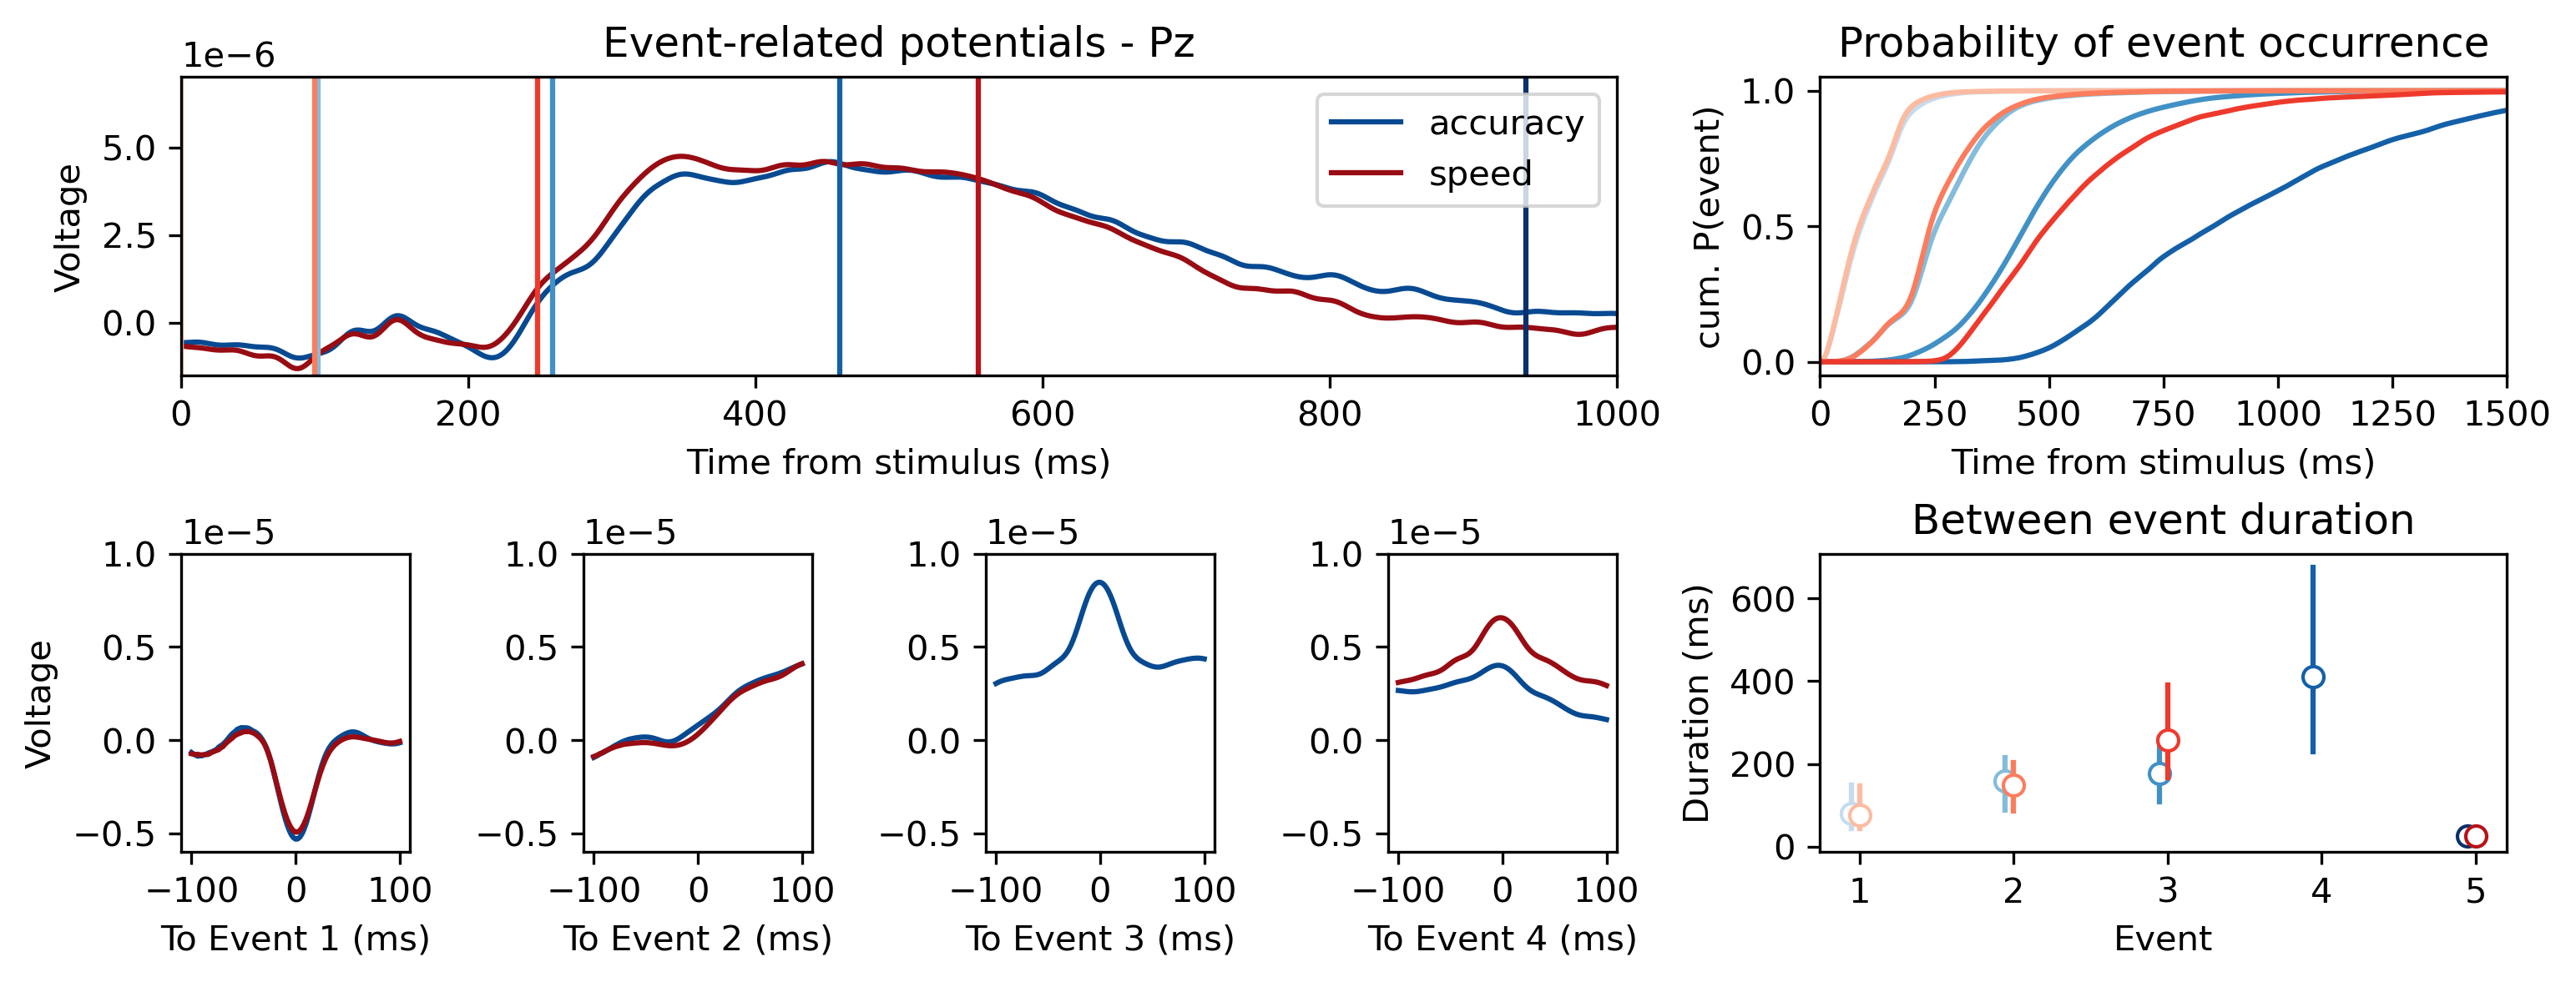

In [19]:
color_cond = {'speed':plt.cm.Reds(.9),'accuracy':plt.cm.Blues(.9)}
fig = plt.figure(constrained_layout=True, figsize=(12, 5), dpi=300)
gs = fig.add_gridspec(3, 6, width_ratios=[1, 1, 1, 1, 3, 2])
tstep = 1000/info['sfreq']

probs_mean_accuracy = estimates_accuracy.eventprobs.mean('trial_x_participant')
probs_mean_speed = estimates_speed.eventprobs.mean('trial_x_participant')

color_ev_speed = {i: plt.cm.Reds(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_accuracy.shape[-1]+1))}
color_ev_accuracy = {i: plt.cm.Blues(x) for i,x in enumerate(np.linspace(.25,1, probs_mean_accuracy.shape[-1]+1))}
color_cond_ev = {'speed':color_ev_speed,'accuracy':color_ev_accuracy}


times_speed = init_speed.compute_times(init_speed, estimates_speed, fill_value=0, add_rt=True)
times_accuracy = init_accuracy.compute_times(init_accuracy, estimates_accuracy, fill_value=0, add_rt=True)
data = epoch_data.stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all")
mean_times_speed = times_speed.mean('trial_x_participant')
mean_times_accuracy = times_accuracy.mean('trial_x_participant')

# Plotting the ERP
ax1 = fig.add_subplot(gs[0, :4])

# Plotting the single trial aligned events
baseline, n_samples = -50, 50
for i, event in enumerate(times_accuracy.event[1:-1]):
    ax = fig.add_subplot(gs[1, i])
    centered = hmp.utils.centered_activity(data, times_accuracy, ["Pz"], event=event, baseline=baseline, n_samples=n_samples)
    ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data*1e-6, color=color_cond['accuracy'])
    if event < 3:
        centered = hmp.utils.centered_activity(data, times_speed, ["Pz"], event=event, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data*1e-6, color=color_cond['speed'])
    elif event == 4:
        centered = hmp.utils.centered_activity(data, times_speed, ["Pz"], event=event-1, baseline=baseline, n_samples=n_samples)
        ax.plot(centered.samples*tstep, centered.data.unstack().mean(['trials', 'channel', 'participant']).data*1e-6, color=color_cond['speed'])
        
    ax.set_ylim(-6e-6,10e-6)
    ax.set_xlabel(f'To Event {event.values} (ms)')
    if i == 0:
        ax.set_ylabel("Voltage")


centered = hmp.utils.centered_activity(data, times_accuracy, ["Pz"], event=0, n_samples=500, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])*1e-6
ax1.plot(centered.samples*tstep, centered.data, color=color_cond['accuracy'], label='accuracy')
centered = hmp.utils.centered_activity(data, times_speed, ["Pz"], event=0, n_samples=500, baseline=0).data.unstack().mean(['trials', 'channel', 'participant'])*1e-6
ax1.plot(centered.samples*tstep, centered.data, color=color_cond['speed'], label='speed')
ax1.set_xlim(0, 1000)
ax1.set_xlabel('Time from stimulus (ms)')
ax1.set_ylabel('Voltage')
ax1.set_title('Event-related potentials - Pz')
ax1.legend(loc="upper right")

durations_accuracy = init_accuracy.compute_times(init_accuracy, estimates_accuracy, duration=True, mean=False, add_rt=True).T
times_accuracy = init_accuracy.compute_times(init_accuracy, estimates_accuracy, duration=False, mean=False, add_rt=True).T
durations_speed = init_speed.compute_times(init_speed, estimates_speed, duration=True, mean=False, add_rt=True).T
times_speed = init_speed.compute_times(init_speed, estimates_speed, duration=False, mean=False, add_rt=True).T
estim_n_events = len(times_accuracy.event[:-1])

for i in range(estim_n_events + 1):
    ax1.vlines(mean_times_accuracy[i]*tstep, -1, 1, color=color_cond_ev['accuracy'][i])

for i in range(estim_n_events):
    ax1.vlines(mean_times_speed[i]*tstep, -1, 1, color=color_cond_ev['speed'][i])
ax1.set_ylim(-1.5e-6, 7e-6)


ax2_0 = fig.add_subplot(gs[0, 4])
for i in range(estim_n_events):
    ax2_0.plot(probs_mean_accuracy[:, i].samples*tstep, np.cumsum(probs_mean_accuracy[:, i]), color=color_cond_ev['accuracy'][i])
for i in range(estim_n_events-1):
    ax2_0.plot(probs_mean_speed[:, i].samples*tstep, np.cumsum(probs_mean_speed[:, i]), color=color_cond_ev['speed'][i])
ax2_0.set_ylabel('cum. P(event)')
ax2_0.set_xlabel('Time from stimulus (ms)')
ax2_0.set_xlim(0, 1500)
ax2_0.set_title('Probability of event occurrence')


ax2_1 = fig.add_subplot(gs[1, 4])
for i in range(estim_n_events + 1):
    ax2_1.plot(np.repeat(i + 1, 2) - .055, np.percentile(durations_accuracy[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['accuracy'][i])
    ax2_1.plot(i + 1 - .055, np.percentile(durations_accuracy[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['accuracy'][i])
for i in range(estim_n_events):
    if i == 3:
        i_ev = 4
    else: i_ev = i
    ax2_1.plot(np.repeat(i_ev + 1, 2), np.percentile(durations_speed[i, :].T, q=[25, 75])*tstep, color=color_cond_ev['speed'][i])
    ax2_1.plot(i_ev + 1, np.percentile(durations_speed[i, :].T, q=[50])*tstep, 'o', markerfacecolor='w', markeredgecolor=color_cond_ev['speed'][i])

ax2_1.set_xlabel('Event')
ax2_1.set_ylabel('Duration (ms)')
ax2_1.set_title('Between event duration')
plt.savefig('HMP_plot',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

In [20]:
times_accuracy = init_accuracy.compute_times(init_accuracy,estimates_accuracy, duration=False,fill_value=0, add_rt=True, as_time=True)
print(times_accuracy.sel(event=2).mean()*(1000/500))
print(times_accuracy.sel(event=2).std()*(1000/500))

<xarray.DataArray 'eventprobs' ()> Size: 8B
array(517.64027539)
Coordinates:
    event      int64 8B 2
    component  int64 8B 0
<xarray.DataArray 'eventprobs' ()> Size: 8B
array(193.11003355)
Coordinates:
    event      int64 8B 2
    component  int64 8B 0


In [21]:

times_accuracy = init_accuracy.compute_times(init_accuracy,estimates_accuracy, duration=True,fill_value=0, add_rt=True, as_time=True).unstack().to_dataframe(name='Duration').reset_index()
# times_accuracy.loc[times_accuracy.stage == 3, 'Duration'] +=  times_accuracy.loc[times_accuracy.stage == 4, 'Duration'].values##times_accuracy.loc[times_accuracy.stage == 4, 'Duration'] + times_accuracy.loc[times_accuracy.stage == 5, 'Duration']
times_accuracy = times_accuracy[times_accuracy.stage != 3]
times_accuracy.loc[:,'stage'] = times_accuracy.loc[:,'stage'].astype('int')
times_speed = init_speed.compute_times(init_speed,estimates_speed, duration=True,fill_value=0, add_rt=True, as_time=True).unstack().to_dataframe(name='Duration')
times_accuracy = times_accuracy.set_index(times_speed.index.names)
times_speed = times_speed.reset_index()
times_speed.loc[times_speed.stage >= 3,'stage' ] +=1
times_speed = times_speed.set_index(times_accuracy.index.names)

In [ ]:
sat_array = epoch_data.sel(channels='C4', samples=0).squeeze().stack({'trial_x_participant':['participant','epochs']}).data.dropna('trial_x_participant', how="all").to_dataframe()[["channels","cue","data"]].reset_index().set_index(['participant','epochs']).cue
times = pd.concat([times_speed.dropna(),times_accuracy.dropna()]).reset_index().set_index(['participant','trials'])
sat_array.reset_index().rename({'epochs':'trials'},axis=1).set_index(['participant','trials'])
times['Condition'] = sat_array
times = times.rename({'stage':'Event'}, axis=1).reset_index()
times = times.replace({'SP':'Speed','AC':'Accuracy'})
times = times.reset_index()
times = times[times.Event != 3]

duration_model = bmb.Model("Duration ~ 0 + Event + Event:Condition + (0+Event + Event : Condition | participant) ", times, family="gaussian", 
                        categorical='Event', dropna=True)
fit = duration_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Duration_sigma, Event, Event:Condition, Event|participant_sigma, Event|participant_offset, Event:Condition|participant_sigma, Event:Condition|participant_offset]


In [ ]:
az.summary(fit, hdi_prob=.95, var_names=list(fit.posterior.data_vars.keys())[:2])

In [ ]:
import pandas as pd
ev_acc = init_accuracy.compute_topologies(epoch_data,estimates_accuracy,init_accuracy, mean=False).sel(channels='Pz').to_dataframe(name='peak').reset_index(allow_duplicates=True)
ev_acc["condition"] = "AC"
ev_acc = ev_acc[ev_acc.event != 2]
ev_acc.loc[ev_acc.event == 3,"event" ] = 2
ev_spd = init_speed.compute_topologies(epoch_data,estimates_speed,init_speed, mean=False).sel(channels='Pz').to_dataframe(name='peak').reset_index(allow_duplicates=True)
ev_spd["condition"] = "SP"
peak = pd.concat([ev_acc,ev_spd])
peak.peak /= 1e-6
peak.reset_index(drop=True, inplace=True)
peak = peak.iloc[:,2:]
peak

In [ ]:
peak_model = bmb.Model("peak ~ 0 + event + event:condition + (0+event + event : condition | participant) ", peak, family="gaussian", 
                        categorical='event', dropna=True)
results = peak_model.fit()



In [ ]:
az.summary(results, hdi_prob=.95, var_names=list(results.posterior.data_vars.keys())[:2])